In [9]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Divide data into chunks

* I will use last chunk which is the largest one in base line modelling.
* This sample presents the characteristics of population.


In [2]:
# we will use dummy dataframe later

df_dummy = pd.read_pickle('data_cleaned')

In [3]:
def data_stratification(df_, grp_col, n_grp):
    
    '''to divide data in stratified chunks.
    Remaining data to put very last chunk.
    
    Parameters: df_:dataframe
                grp_col: field to get proportions
                n_grp: number of desired group
            
    Return: the index numbers of each group within a dictionary
    
    '''
    
    idx_dict = {}
    n = n_grp

    for i in range(n_grp):

        idx=[]  

        for grp in df_[grp_col].unique():

            data = df_[df_[grp_col]==grp]
            num_data = len(data)//(n_grp)
            pro_data = len(data)/(n_grp)
            
            if n_grp > 1:

                if num_data >= 1:
                    idx.append(list(data.sample(num_data, replace=True).index))

                elif (pro_data <= 1) & (pro_data > 0):
                    idx.append(list(data.sample(1, replace=True).index))

            elif n_grp == 1:
                idx.append(list(data.index))

        idx = list(set([col for row in idx for col in row]))    
        idx_dict[i+1] = idx   
        n_grp -= 1
        df_.drop(index=idx, inplace=True)
    
    idx_dict[0] = idx_dict[n]
    idx_dict.pop(n, None)
    idx_dict = dict(sorted(idx_dict.items()))
    
    return idx_dict

In [4]:
df_ = df_dummy[['Model_1', 'Year']] 
df_['Group'] = df_.Model_1 +' '+ df_.Year.astype('str')

In [5]:
idx_grp = data_stratification(df_, 'Group', 18)

In [6]:
x = 0

for i in idx_grp.keys():
    x += len(idx_grp[i])
    print(f'Data points in {i} = {len(idx_grp[i])}, cum_tot = {x}')

Data points in 0 = 9069, cum_tot = 9069
Data points in 1 = 5699, cum_tot = 14768
Data points in 2 = 5754, cum_tot = 20522
Data points in 3 = 5737, cum_tot = 26259
Data points in 4 = 5753, cum_tot = 32012
Data points in 5 = 5736, cum_tot = 37748
Data points in 6 = 5750, cum_tot = 43498
Data points in 7 = 5760, cum_tot = 49258
Data points in 8 = 5785, cum_tot = 55043
Data points in 9 = 5780, cum_tot = 60823
Data points in 10 = 5772, cum_tot = 66595
Data points in 11 = 5813, cum_tot = 72408
Data points in 12 = 5854, cum_tot = 78262
Data points in 13 = 5848, cum_tot = 84110
Data points in 14 = 5836, cum_tot = 89946
Data points in 15 = 5869, cum_tot = 95815
Data points in 16 = 5910, cum_tot = 101725
Data points in 17 = 5859, cum_tot = 107584


In [7]:
# load encoded data for baseline modelling

df=pd.read_pickle("data_encoded")

pd.set_option('display.max_columns', None)

In [8]:
df.head()

,Price,Milage,Year,Power,Consumption,Cylinder,Gears,CO2 emission,Door,Seat,Engine size,Make_Ford,Make_Toyota,Make_Vauxhall,Make_Volkswagen,Fuel Type_Diesel,Fuel Type_Electric,Fuel Type_Hybrid,Fuel Type_Petrol,Transmission_Automatic,Transmission_Manual,Body type_Coupe,Body type_Estate,Body type_Hatchback,Body type_SUV,Body type_Saloon,Body type_Van,data_source_autotrader,data_source_cargurus,data_source_parkers,data_source_theaa,Model_1_ADAM,Model_1_Astra,Model_1_Auris,Model_1_Avensis,Model_1_Aygo,Model_1_Corsa,Model_1_Fiesta,Model_1_Focus,Model_1_Golf,Model_1_Insignia,Model_1_KA,Model_1_Kuga,Model_1_Mokka,Model_1_Mondeo,Model_1_Passat,Model_1_Polo,Model_1_RAV4,Model_1_Scirocco,Model_1_Tiguan,Model_1_Yaris
0,2199.0,83000.0,2008,67.0,51.4,3.0,5.0,108.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,995.0,130000.0,2006,67.0,51.4,3.0,5.0,108.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6695.0,39000.0,2017,67.0,56.5,3.0,5.0,95.0,5.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2495.0,73000.0,2007,67.0,51.4,3.0,5.0,109.0,3.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5995.0,57796.0,2015,67.0,56.5,3.0,5.0,95.0,5.0,4.0,1.0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(107584, 51)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107584 entries, 0 to 111738
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Price                   107584 non-null  float64
 1   Milage                  107584 non-null  float64
 2   Year                    107584 non-null  int32  
 3   Power                   107584 non-null  float64
 4   Consumption             107584 non-null  float64
 5   Cylinder                107584 non-null  float64
 6   Gears                   107584 non-null  float64
 7   CO2 emission            107584 non-null  float64
 8   Door                    107584 non-null  float64
 9   Seat                    107584 non-null  float64
 10  Engine size             107584 non-null  float64
 11  Make_Ford               107584 non-null  uint8  
 12  Make_Toyota             107584 non-null  uint8  
 13  Make_Vauxhall           107584 non-null  uint8  
 14  Make_Volkswagen     

<AxesSubplot:>

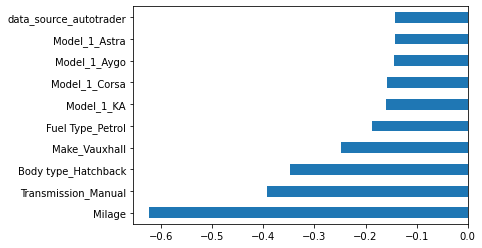

In [11]:
# mileage, transmission, body_type, year, power, and make are correlated with price

df.corr()["Price"].sort_values().head(10).plot.barh()

<AxesSubplot:>

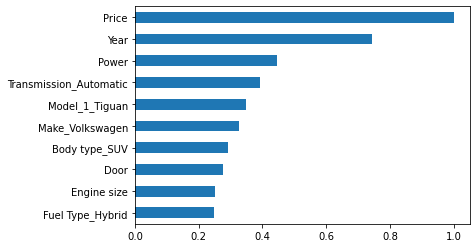

In [11]:
df.corr()["Price"].sort_values().tail(10).plot.barh()

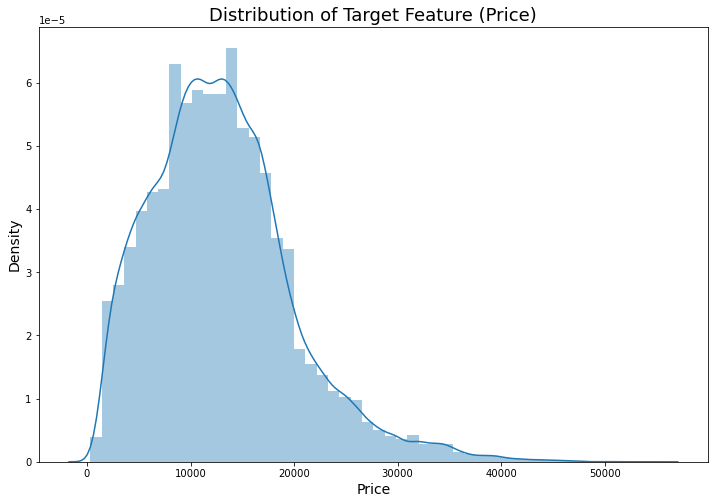

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(df.Price)
plt.title('Distribution of Target Feature (Price)', fontdict={'fontsize':18})
plt.xlabel('Price', fontdict={'fontsize':14})
plt.ylabel('Density', fontdict={'fontsize':14});

<AxesSubplot:xlabel='Price'>

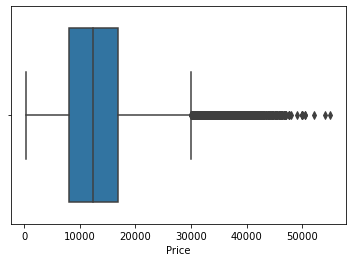

In [13]:
sns.boxplot(df.Price, orient="v")

### Data for Baseline Model

In [14]:
# group 0 contains around 10000 data points.

group0 = list(idx_grp[0])
df_baseline = df.loc[group0]

In [15]:
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9069 entries, 65539 to 65534
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   9069 non-null   float64
 1   Milage                  9069 non-null   float64
 2   Year                    9069 non-null   int32  
 3   Power                   9069 non-null   float64
 4   Consumption             9069 non-null   float64
 5   Cylinder                9069 non-null   float64
 6   Gears                   9069 non-null   float64
 7   CO2 emission            9069 non-null   float64
 8   Door                    9069 non-null   float64
 9   Seat                    9069 non-null   float64
 10  Engine size             9069 non-null   float64
 11  Make_Ford               9069 non-null   uint8  
 12  Make_Toyota             9069 non-null   uint8  
 13  Make_Vauxhall           9069 non-null   uint8  
 14  Make_Volkswagen         9069 non-nu

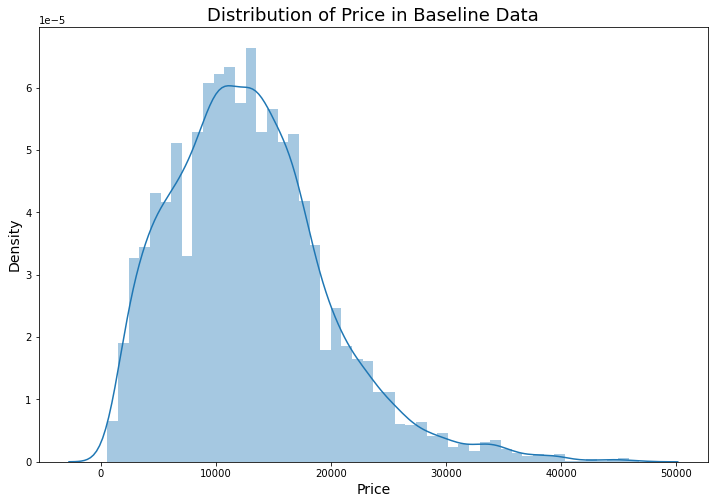

In [16]:
# These data points are the largest stratified chunk of population 

plt.figure(figsize=(12,8))
sns.distplot(df_baseline.Price)
plt.title('Distribution of Price in Baseline Data', fontdict={'fontsize':18})
plt.xlabel('Price', fontdict={'fontsize':14})
plt.ylabel('Density', fontdict={'fontsize':14});



<AxesSubplot:xlabel='Price'>

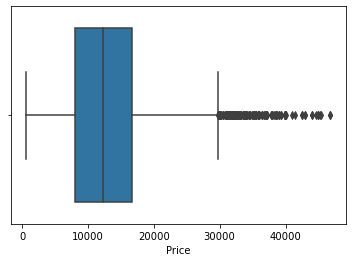

In [17]:
sns.boxplot(df_baseline.Price, orient="v")

In [18]:
df_baseline.columns

Index(['Price', 'Milage', 'Year', 'Power', 'Consumption', 'Cylinder', 'Gears',
       'CO2 emission', 'Door', 'Seat', 'Engine size', 'Make_Ford',
       'Make_Toyota', 'Make_Vauxhall', 'Make_Volkswagen', 'Fuel Type_Diesel',
       'Fuel Type_Electric', 'Fuel Type_Hybrid', 'Fuel Type_Petrol',
       'Transmission_Automatic', 'Transmission_Manual', 'Body type_Coupe',
       'Body type_Estate', 'Body type_Hatchback', 'Body type_SUV',
       'Body type_Saloon', 'Body type_Van', 'data_source_autotrader',
       'data_source_cargurus', 'data_source_parkers', 'data_source_theaa',
       'Model_1_ADAM', 'Model_1_Astra', 'Model_1_Auris', 'Model_1_Avensis',
       'Model_1_Aygo', 'Model_1_Corsa', 'Model_1_Fiesta', 'Model_1_Focus',
       'Model_1_Golf', 'Model_1_Insignia', 'Model_1_KA', 'Model_1_Kuga',
       'Model_1_Mokka', 'Model_1_Mondeo', 'Model_1_Passat', 'Model_1_Polo',
       'Model_1_RAV4', 'Model_1_Scirocco', 'Model_1_Tiguan', 'Model_1_Yaris'],
      dtype='object')

In [19]:
target_col = df_baseline.columns[0]

field_cols = df_baseline.columns[1:]

X = df_baseline[field_cols]
y = df_baseline[target_col]

In [20]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [21]:
def eval_metrics(actual, pred):
    '''to evaluate performance of regression model
    
    Parameters: actual: actual values
                pred: predicted value
                
    Return: pandas series of evaluations metrics of ML model            
    '''
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    per_mae = np.mean(abs(a.actual - a.pred)/a.actual * 100)
    mse = mean_squared_error(actual, pred)
    r_score = r2_score(actual, pred)
    corr = a.actual.corr(a.pred)
    
    data = pd.Series([r_score, mae, per_mae, mse, rmse, corr], index=['R2 score', 'MAE', '% of MAE', 'MSE', 'RMSE', 'Correlation'])
    return data.round(3)

# 1.Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lm = LinearRegression()

In [24]:
lm.fit(X_train, y_train)

LinearRegression()

In [25]:
lm.intercept_

-1952990.3250065031

In [26]:
lm.coef_

array([-6.20676046e-02,  9.70667259e+02,  2.30209814e+01,  1.51055812e+01,
        1.07511449e+01,  5.70817595e+02,  1.12354870e+01, -3.65611360e+01,
        5.80994047e+02,  2.53962323e+03,  1.22150589e+02, -5.47961164e+01,
       -1.94610783e+03,  1.87875336e+03, -3.45668240e+03,  5.81008492e+03,
        2.05027609e+02, -2.55843012e+03,  9.57675148e+02, -9.57675148e+02,
       -4.50019359e+02,  2.84000469e+02,  1.45532687e+02,  6.95209687e+02,
       -9.64928709e+02,  2.90205224e+02, -4.83458296e+02, -3.23535660e+02,
        1.09020615e+03, -2.83212190e+02, -7.19013072e+01, -2.74049497e+02,
        5.77091664e+02,  4.61168588e+02, -1.38630730e+03, -2.50736905e+02,
       -3.44005175e+02,  8.93684713e+02,  2.60520659e+02, -3.05673146e+02,
       -9.09530403e+02,  1.16592176e+03, -1.04374697e+03, -6.83920303e+02,
        3.15183904e+02, -1.09843284e+03,  2.42792814e+03, -4.67268112e+02,
        2.86874974e+03, -2.13467721e+03])

In [27]:
# predict price for test set

y_pred = lm.predict(X_test)

In [28]:
# store evalueation metrics values of model for comparison purposes

lm_scores = eval_metrics(y_test, y_pred)
lm_scores

R2 score             0.875
MAE               1748.138
% of MAE            21.191
MSE            6045691.935
RMSE              2458.799
Correlation          0.935
dtype: float64

In [29]:
def act_pred_data(actual, pred):
    '''create a df with actual, predicted and % of errors
    
    Parameters: actual: str: actual values
                pred: str: predicted values
    Returns a df
    '''
    a = pd.DataFrame({'actual': actual, 'pred': pred})
    a['per_err'] = abs(a.actual - a.pred)/a.actual * 100
    
    return a

In [30]:
lm_df = act_pred_data(y_test, y_pred)

In [31]:
lm_df

,actual,pred,per_err
17242,14501.0,15285.210588,5.407976
28605,2500.0,2828.937704,13.157508
88176,16590.0,17194.449285,3.643456
29113,11570.0,12998.075627,12.342918
82635,20599.0,18615.488404,9.629165
...,...,...,...
26888,11599.0,13016.840334,12.223815
105316,17350.0,16597.084731,4.339569
9832,15000.0,14033.337130,6.444419
80135,12495.0,14802.772015,18.469564


In [32]:
def scatter_corr(actual, pred, df):
    '''to draw a scatter plot of actual values vs predicted value with correlation of them
    Parameters: actual: str: actual values
                pred: str: predicted values
                df: dataframe
    
    Return: scatter plot of actual value vs predicted value
    '''
    correlation = np.mean(abs(df[actual] - df[pred])/df[actual] * 100)
    
    x = [i for i in range(int(np.min(df[actual])), int(np.max(df[actual])))]
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=actual, y=pred, data=df)
    plt.plot(x, x, color='black')
    plt.plot(np.unique(df[actual]), np.poly1d(np.polyfit(df[actual], df[pred], 1))
             (np.unique(df[actual])), color='red')
    plt.title(f'Error Rate: {correlation:.2f}%', 
              fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Actual Values', fontdict={'size':15, 'color':'black'})
    plt.ylabel('Predicted Values',fontdict={'size':15, 'color':'black'})

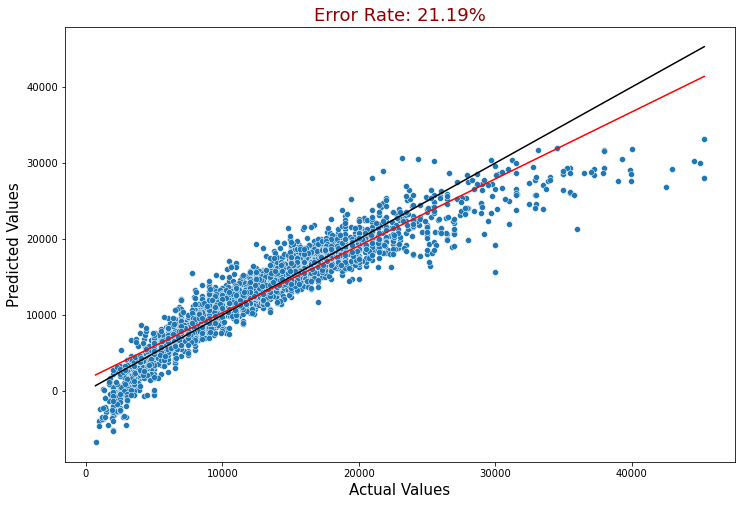

In [33]:
# it is expected to data points gathered around black line

scatter_corr('actual', 'pred', lm_df)

* Linear model didn't work very well predicting high and low values.
* Predictions are acceptable between £3000 - £2800 range

## 1.2 Cross validation

In [34]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(estimator=lm, X=X_train, y=y_train, cv=5)
cv_scores.mean()

0.8811063577784803

In [35]:
cv_scores

array([0.87661214, 0.8871469 , 0.86921781, 0.89390502, 0.87864992])

In [36]:
accuraries = cross_val_score(estimator=lm, X=X_train, y=y_train, scoring = "neg_mean_squared_error", cv=10)
accuraries

array([-6163728.28912741, -5558377.65976901, -4902398.89598091,
       -5292640.60912415, -8072858.07850433, -6254805.58362923,
       -4489869.64783433, -4130007.62753292, -5383834.76317685,
       -5642164.12830699])

In [37]:
-accuraries.mean()

5589068.528298614

# 2. Ridge Regression

In [38]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [39]:
ridge_model = Ridge(normalize=True)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [40]:
ridge_scores = eval_metrics(y_test, y_pred)
ridge_scores

R2 score       7.880000e-01
MAE            2.230236e+03
% of MAE       2.234600e+01
MSE            1.023883e+07
RMSE           3.199817e+03
Correlation    9.200000e-01
dtype: float64

In [41]:
ridge_df = act_pred_data(y_test, y_pred)

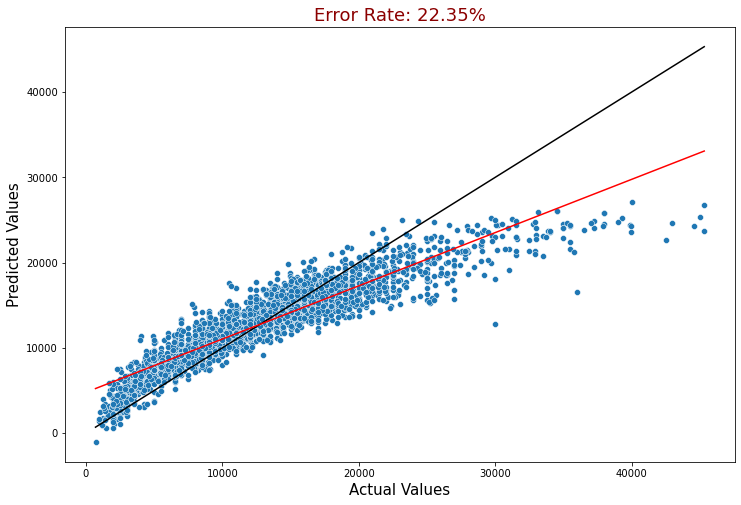

In [42]:
scatter_corr('actual', 'pred', ridge_df)

* Ridge regression worked better on low values 
* Predictions are not acceptable for above £22000 range. 

### 2.1 Ridge Cross validation and Alpha tuning

In [43]:
# deciding alpha parameter.

alpha_space = np.linspace(0.1, 20, 100)

In [44]:
ridgecv = RidgeCV(alphas = alpha_space, normalize =True, cv = 5)
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1       ,  0.3010101 ,  0.5020202 ,  0.7030303 ,  0.9040404 ,
        1.10505051,  1.30606061,  1.50707071,  1.70808081,  1.90909091,
        2.11010101,  2.31111111,  2.51212121,  2.71313131,  2.91414141,
        3.11515152,  3.31616162,  3.51717172,  3.71818182,  3.91919192,
        4.12020202,  4.32121212,  4.52222222,  4.72323232,  4.92424242,
        5.12525253,  5.32626263,  5.52727273,  5.72828283,  5.92929293,
        6.1303030...
       14.17070707, 14.37171717, 14.57272727, 14.77373737, 14.97474747,
       15.17575758, 15.37676768, 15.57777778, 15.77878788, 15.97979798,
       16.18080808, 16.38181818, 16.58282828, 16.78383838, 16.98484848,
       17.18585859, 17.38686869, 17.58787879, 17.78888889, 17.98989899,
       18.19090909, 18.39191919, 18.59292929, 18.79393939, 18.99494949,
       19.1959596 , 19.3969697 , 19.5979798 , 19.7989899 , 20.        ]),
        cv=5, normalize=True)

In [45]:
ridgecv.alpha_

0.1

In [46]:
ridge_model = Ridge(alpha=0.01, normalize=True)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [47]:
ridgecv_scores = eval_metrics(y_test, y_pred)
ridgecv_scores

R2 score             0.875
MAE               1745.460
% of MAE            20.992
MSE            6047096.016
RMSE              2459.084
Correlation          0.935
dtype: float64

In [48]:
ridgecv_df = act_pred_data(y_test, y_pred)

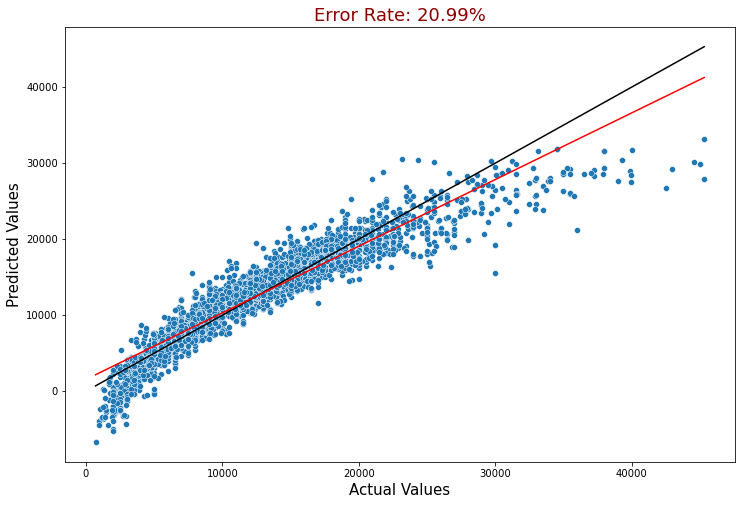

In [49]:
scatter_corr('actual', 'pred', ridgecv_df)

* model become better for higher values however became weak for low values
* similar to above linear model

# 3. Lasso Regression

In [50]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [51]:
lasso_model = Lasso(normalize=True)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
eval_metrics(y_test, y_pred)

R2 score             0.873
MAE               1756.313
% of MAE            20.697
MSE            6152469.598
RMSE              2480.417
Correlation          0.934
dtype: float64

In [52]:
lasso_scores = eval_metrics(y_test, y_pred)
lasso_scores

R2 score             0.873
MAE               1756.313
% of MAE            20.697
MSE            6152469.598
RMSE              2480.417
Correlation          0.934
dtype: float64

In [53]:
lasso_df = act_pred_data(y_test, y_pred)

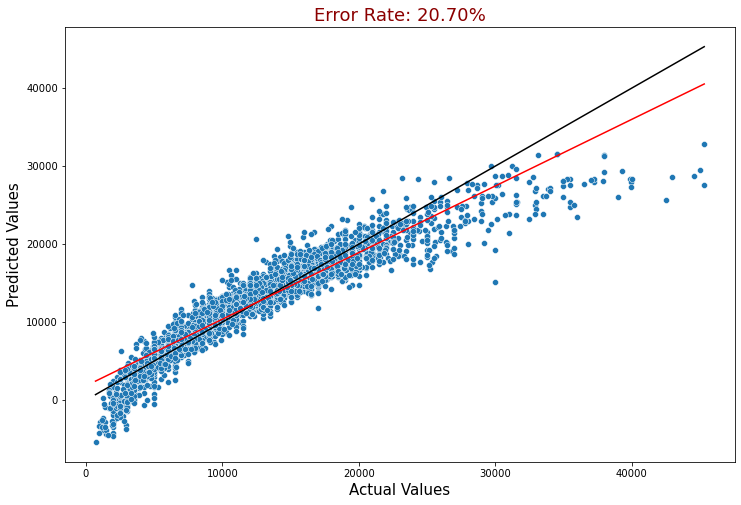

In [54]:
scatter_corr('actual', 'pred', lasso_df)

### 3.1 Lasso Regression with cross validation

In [55]:
lassocv = LassoCV(alphas = alpha_space, normalize =True, cv = 5)
lassocv.fit(X_train, y_train)
y_pred = lassocv.predict(X_test)

In [56]:
lassocv.alpha_

0.1

In [57]:
lassocv_scores = eval_metrics(y_test, y_pred)
lassocv_scores

R2 score             0.875
MAE               1745.435
% of MAE            21.100
MSE            6040210.201
RMSE              2457.684
Correlation          0.935
dtype: float64

In [58]:
lassocv_df = act_pred_data(y_test, y_pred)

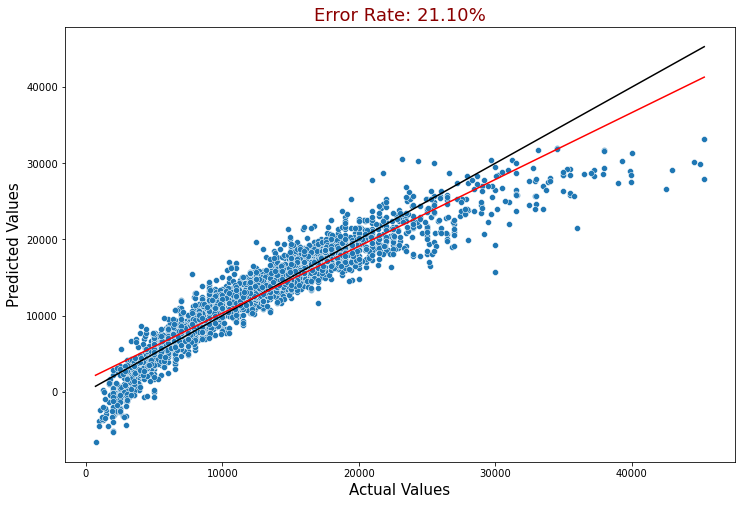

In [59]:
scatter_corr('actual', 'pred', lassocv_df)

### 3.2 Lasso Reg without normalization

In [60]:
lassocv = LassoCV(alphas = alpha_space, normalize =False, cv = 5)
lassocv.fit(X_train, y_train)

LassoCV(alphas=array([ 0.1       ,  0.3010101 ,  0.5020202 ,  0.7030303 ,  0.9040404 ,
        1.10505051,  1.30606061,  1.50707071,  1.70808081,  1.90909091,
        2.11010101,  2.31111111,  2.51212121,  2.71313131,  2.91414141,
        3.11515152,  3.31616162,  3.51717172,  3.71818182,  3.91919192,
        4.12020202,  4.32121212,  4.52222222,  4.72323232,  4.92424242,
        5.12525253,  5.32626263,  5.52727273,  5.72828283,  5.92929293,
        6.1303030...
       14.17070707, 14.37171717, 14.57272727, 14.77373737, 14.97474747,
       15.17575758, 15.37676768, 15.57777778, 15.77878788, 15.97979798,
       16.18080808, 16.38181818, 16.58282828, 16.78383838, 16.98484848,
       17.18585859, 17.38686869, 17.58787879, 17.78888889, 17.98989899,
       18.19090909, 18.39191919, 18.59292929, 18.79393939, 18.99494949,
       19.1959596 , 19.3969697 , 19.5979798 , 19.7989899 , 20.        ]),
        cv=5, normalize=False)

In [61]:
lassocv.alpha_

0.301010101010101

In [62]:
# alpha is greater

lasso_model = Lasso(alpha=1.9, normalize=False)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
lassocv_Nnorm_scores = eval_metrics(y_test, y_pred)
lassocv_Nnorm_scores


R2 score             0.875
MAE               1746.337
% of MAE            21.218
MSE            6036775.094
RMSE              2456.985
Correlation          0.935
dtype: float64

In [63]:
# and the score is better

In [64]:
feature_coef = pd.DataFrame({'features' : X.columns, 'coef' : lasso_model.coef_})

In [65]:
feature_coef.head()

,features,coef
0,Milage,-0.062133
1,Year,969.157437
2,Power,26.057157
3,Consumption,11.985922
4,Cylinder,228.056438


In [66]:
feature_coef.shape

(50, 2)

In [67]:
# Lasso penalise by 0 coef

significant_features = feature_coef.loc[feature_coef.coef != 0, :]
len(significant_features)

41

In [68]:
# increase alpha to lower number of features

lasso_model = Lasso(alpha=500, normalize=False)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)


In [69]:
feature_coef = pd.DataFrame({'features' : X.columns, 'coef' : lasso_model.coef_})
significant_features = feature_coef.loc[feature_coef.coef != 0, :]
len(significant_features)

7

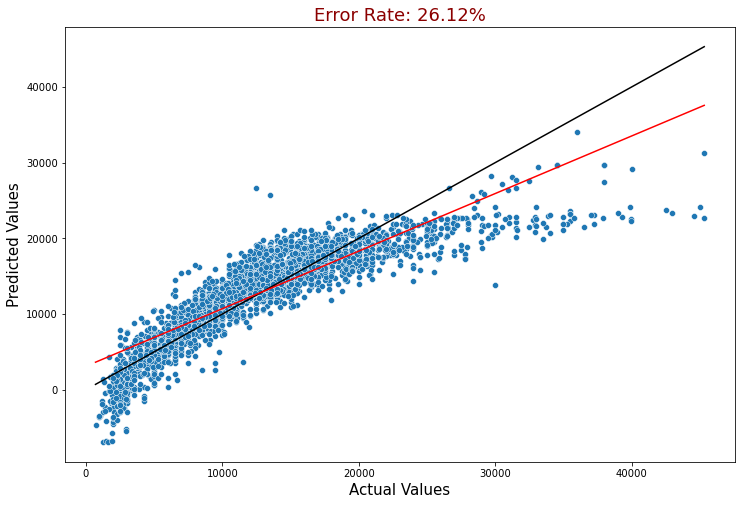

In [70]:
a = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', a)

In [71]:
significant_features.sort_values(by="coef", ascending=False)

,features,coef
1,Year,8.453913e+02
18,Transmission_Automatic,1.221912e+02
2,Power,9.984146e+01
6,CO2 emission,2.404970e+00
19,Transmission_Manual,-2.401745e-12
0,Milage,-7.732336e-02
3,Consumption,-6.613148e+00


In [72]:
lasso_scores_low_dim = eval_metrics(y_test, y_pred)
lasso_scores_low_dim.round(2)

R2 score              0.76
MAE                2400.35
% of MAE             26.12
MSE            11378380.63
RMSE               3373.19
Correlation           0.87
dtype: float64

# 4. Random Forest Regressor

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rf_reg = RandomForestRegressor()

In [75]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [76]:
y_pred = rf_reg.predict(X_test)

In [77]:
rf_score = eval_metrics(y_test, y_pred)
rf_score

R2 score             0.953
MAE               1038.745
% of MAE             9.475
MSE            2271440.577
RMSE              1507.130
Correlation          0.976
dtype: float64

### 4.1 RF cross validation

In [78]:
cv_scores = cross_val_score(estimator=rf_reg, X=X_train, y=y_train, cv=3)
cv_scores.mean()

0.9458491819746445

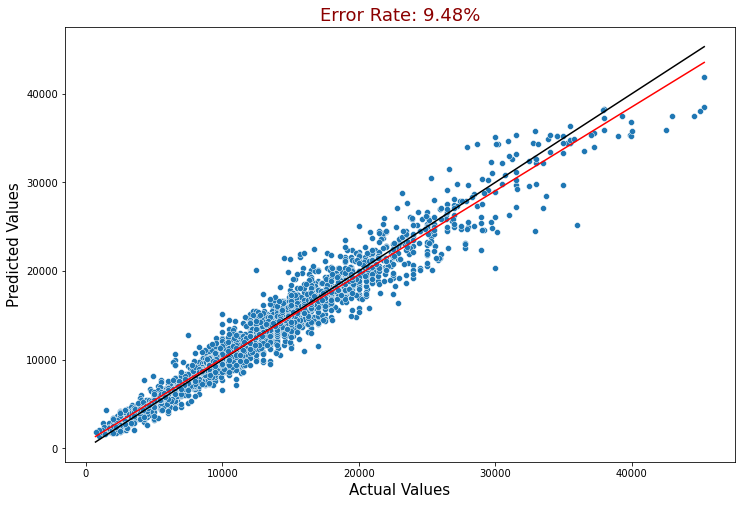

In [79]:
rf_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_df)

* Random forest worked best among linear, Ridge, Lasso regression.
* Regression line almost overlap with diagonal which indicates similartiy of actual and predicted values.

## RF Feature Importance

In [80]:
rf_reg.feature_importances_

array([5.42288819e-02, 6.14674900e-01, 2.10823270e-01, 8.79482172e-03,
       2.77510506e-04, 1.80355225e-03, 1.78846052e-02, 1.15266075e-03,
       5.06246875e-04, 1.38944518e-02, 1.48640038e-03, 1.87641206e-03,
       1.49889927e-03, 2.55898341e-03, 8.87661250e-04, 5.37690651e-04,
       2.56906613e-03, 9.33364512e-04, 1.77135133e-02, 1.81576006e-02,
       2.80124474e-05, 8.07643544e-04, 2.14158406e-03, 6.82724954e-04,
       4.54304427e-04, 7.54063594e-05, 6.92605754e-04, 1.14469331e-03,
       8.26417799e-05, 1.20047734e-03, 2.58465849e-05, 4.75871020e-04,
       9.35579734e-05, 5.14666674e-05, 4.68952724e-04, 1.80409510e-04,
       3.19196232e-04, 4.45772807e-03, 1.88725754e-03, 3.15321695e-04,
       1.69934866e-04, 4.18379028e-04, 6.96640949e-05, 3.64421854e-04,
       3.63502932e-04, 3.71800629e-04, 1.34754010e-03, 1.28108588e-04,
       8.71926835e-03, 2.01185620e-04])

In [81]:
importance = pd.DataFrame({'importance':rf_reg.feature_importances_}, 
                          index = X_train.columns)

In [82]:
importance.sort_values(by="importance", ascending = False).head(10)

,importance
Year,0.614675
Power,0.210823
Milage,0.054229
Transmission_Manual,0.018158
CO2 emission,0.017885
Transmission_Automatic,0.017714
Engine size,0.013894
Consumption,0.008795
Model_1_Tiguan,0.008719
Model_1_Focus,0.004458


<AxesSubplot:>

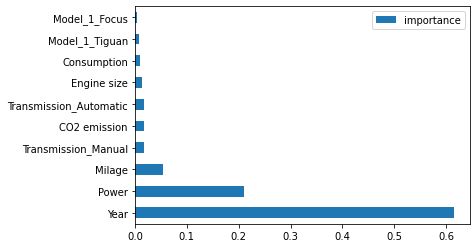

In [83]:
importance.sort_values(by="importance", ascending = False).head(10).plot.barh()

## Feature Selection with RF

In [97]:
best_features_rf = ["Year", "Power", "Milage", "Make", "Model_1"]  #feature selection

In [98]:
X = df_dummy.loc[group0][best_features_rf]
y = df_dummy.loc[group0]["Price"]

In [99]:
X.shape

(9069, 5)

In [100]:
X = pd.get_dummies(X)

In [101]:
X.shape

(9069, 27)

In [102]:
X.head()

,Year,Power,Milage,Make_Ford,Make_Toyota,Make_Vauxhall,Make_Volkswagen,Model_1_ADAM,Model_1_Astra,Model_1_Auris,Model_1_Avensis,Model_1_Aygo,Model_1_Corsa,Model_1_Fiesta,Model_1_Focus,Model_1_Golf,Model_1_Insignia,Model_1_KA,Model_1_Kuga,Model_1_Mokka,Model_1_Mondeo,Model_1_Passat,Model_1_Polo,Model_1_RAV4,Model_1_Scirocco,Model_1_Tiguan,Model_1_Yaris
65539,2018,74.0,23508.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65540,2020,74.0,3960.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98313,2019,123.0,33095.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
65553,2009,74.0,55000.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32786,2016,118.0,90922.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [104]:
rf_reg_5f = RandomForestRegressor()

In [105]:
rf_reg_5f.fit(X_train, y_train)

RandomForestRegressor()

In [106]:
y_pred = rf_reg_5f.predict(X_test)

In [107]:
rf_reg_5f_scores = eval_metrics(y_test, y_pred)
rf_reg_5f_scores

R2 score             0.900
MAE               1506.069
% of MAE            13.021
MSE            4837345.944
RMSE              2199.397
Correlation          0.949
dtype: float64

In [108]:
accuraries = cross_val_score(estimator=rf_reg_5f, X=X_train, y=y_train, cv=5)
accuraries.mean()

0.8937500160318722

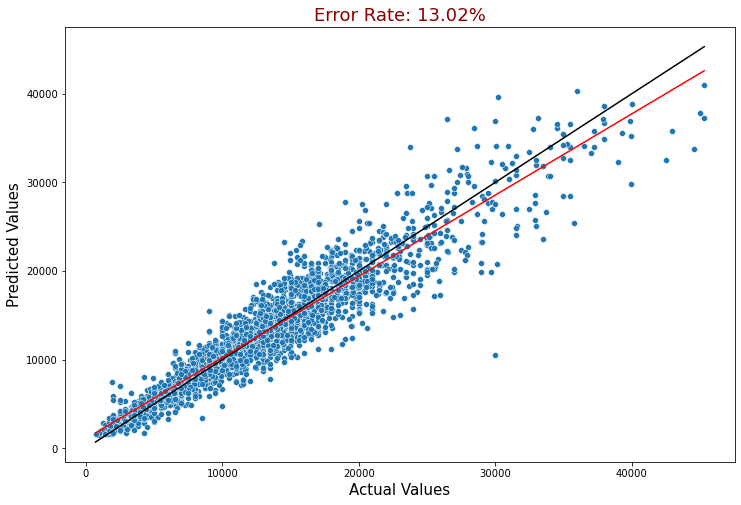

In [109]:
rf_df_5f = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_df_5f)

## RF Model Tunning

In [110]:
rf_params = {"n_estimators":[50, 100, 300],
              "max_depth":[3,5,7],
              "max_features": [2,4,6,8],
              "min_samples_split": [2,4,6]}

In [111]:
rf_cv_model = GridSearchCV(rf_reg_3f, rf_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [112]:
rf_cv_model.best_params_

{'max_depth': 7,
 'max_features': 8,
 'min_samples_split': 4,
 'n_estimators': 300}

In [113]:
rf_tuned_5f = RandomForestRegressor(max_features = 6,
                                min_samples_split = 6,
                                 n_estimators = 100)
rf_tuned_5f.fit(X_train, y_train)

RandomForestRegressor(max_features=6, min_samples_split=6)

In [114]:
y_pred = rf_tuned_5f.predict(X_test)
rf_tuned_5f_scores = eval_metrics(y_test,y_pred)
rf_tuned_5f_scores

R2 score             0.911
MAE               1431.437
% of MAE            12.655
MSE            4318137.935
RMSE              2078.013
Correlation          0.954
dtype: float64

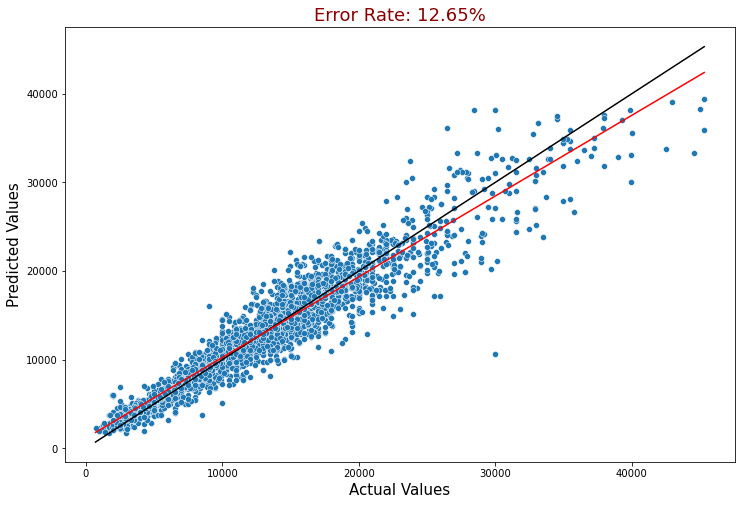

In [115]:
rf_tuned_5f_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', rf_tuned_5f_df)

## 5. XGBOOST Regressor

In [152]:
import xgboost

In [153]:
X = df_baseline[field_cols]
y = df_baseline[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [154]:
model_xg = xgboost.XGBRegressor()
model_xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [155]:
y_pred = model_xg.predict(X_test)

In [156]:
xgb_scores=eval_metrics(y_test, y_pred)
xgb_scores

R2 score             0.958
MAE                989.571
% of MAE             8.936
MSE            2033313.988
RMSE              1425.943
Correlation          0.979
dtype: float64

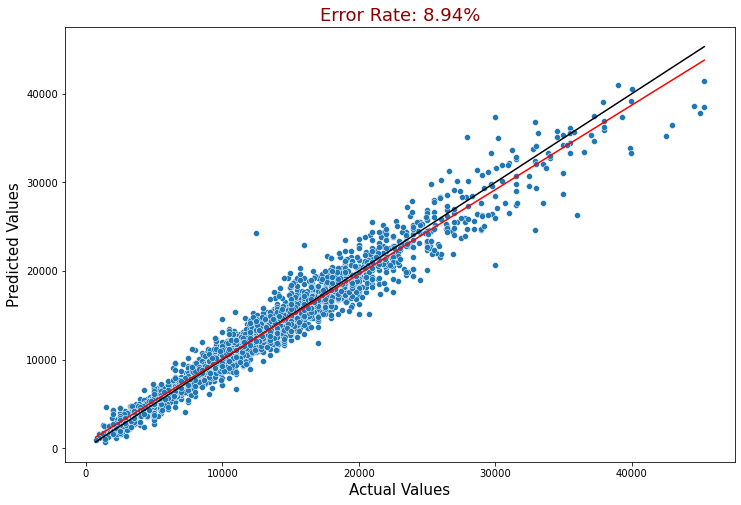

In [158]:
xgb_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgb_df)

## With selected features

In [121]:
new_list = ["Year", "Power", "Milage", "Make", "Model_1"]

In [122]:
X=df_dummy[new_list]
y=df_dummy['Price']
X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [123]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [124]:
y_pred = model.predict(X_test)
xgb_5F_scores = eval_metrics(y_test, y_pred)
xgb_5F_scores

R2 score             0.925
MAE               1292.185
% of MAE            10.891
MSE            3570155.665
RMSE              1889.486
Correlation          0.962
dtype: float64

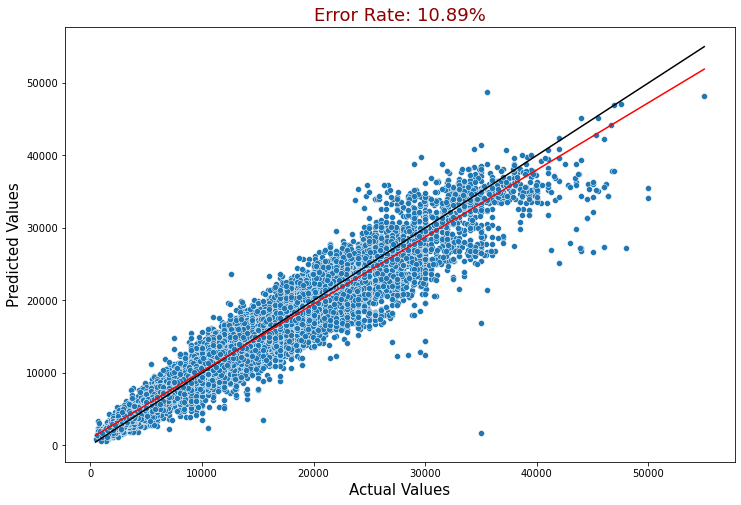

In [125]:
xgb_5F_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgb_5F_df)

## Tuning xgboost

In [117]:
xgb_params = {"n_estimators": [50, 100, 300],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [118]:
from sklearn.model_selection import GridSearchCV
xgb_cv_model  = GridSearchCV(model,xgb_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [119]:
xgb_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

In [120]:
xgb_tuned = xgboost.XGBRegressor(subsample = 1, 
                         learning_rate = 0.1, 
                         max_depth = 7, 
                         n_estimators = 100).fit(X_train, y_train)

In [121]:
y_pred = xgb_tuned.predict(X_test)
xgbcv_5F_df = eval_metrics(y_test,y_pred)
xgbcv_5F_df

R2 score             0.925
MAE               1295.209
% of MAE            10.920
MSE            3577671.138
RMSE              1891.473
Correlation          0.962
dtype: float64

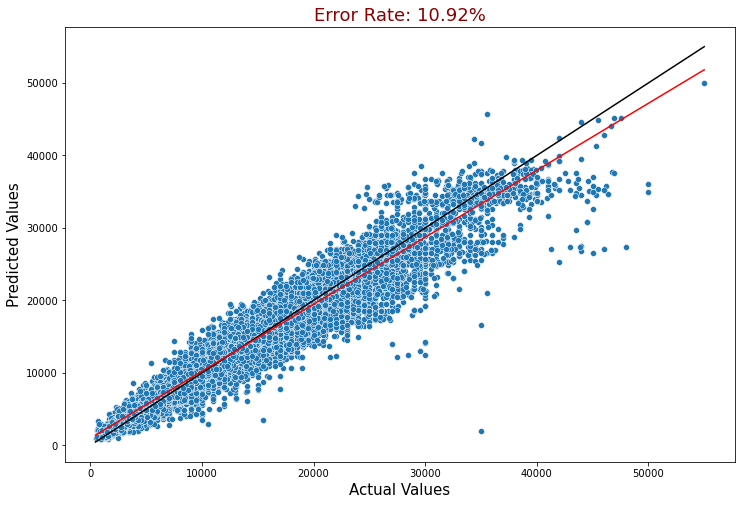

In [122]:
xgbcv_5F_df = act_pred_data(y_test, y_pred)
scatter_corr('actual', 'pred', xgbcv_5F_df)

In [123]:
a

,actual,pred,per_err
87877,7750.0,10634.928682,37.224886
22599,14150.0,15456.466400,9.232978
50203,10395.0,7035.741495,32.316099
78356,7500.0,14617.578279,94.901044
89588,6995.0,8354.191592,19.430902
...,...,...,...
46698,25997.0,21739.165857,16.378175
81604,24995.0,20525.499203,17.881580
60386,13450.0,15602.116316,16.000865
95464,13489.0,15290.120577,13.352514


## Comparison of models

In [136]:
data = [lm_scores, ridgecv_scores, lassocv_scores, rf_score,xgb_scores ,lasso_scores_low_dim.round(2), rf_tuned_5f_scores, xgb_5F_scores]
cols={0:'Linear_Reg',  1:'Ridge_CV', 2:'Lasso_CV', 3:'Random_Forest',4:'XGBoost', 5: 'Lasso_5F', 6:'Random_Forest_5F', 7:'XGB_5F'}
df_scores = pd.concat(data, axis=1)

In [137]:
df_scores.rename(columns=cols, inplace=True)

In [138]:
df_scores

,Linear_Reg,Ridge_CV,Lasso_CV,Random_Forest,XGBoost,Lasso_5F,Random_Forest_5F,XGB_5F
R2 score,0.875,0.875,0.875,0.953,0.958,0.76,0.911,0.925
MAE,1748.138,1745.460,1745.435,1038.745,989.571,2400.35,1431.437,1292.185
% of MAE,21.191,20.992,21.100,9.475,8.936,26.12,12.655,10.891
MSE,6045691.935,6047096.016,6040210.201,2271440.577,2033313.988,11378380.63,4318137.935,3570155.665
RMSE,2458.799,2459.084,2457.684,1507.130,1425.943,3373.19,2078.013,1889.486
Correlation,0.935,0.935,0.935,0.976,0.979,0.87,0.954,0.962


In [143]:
def ploting(row):
    plt.figure(figsize=(10,8))
    plt.bar(['Linear_Reg','Ridge_CV','Lasso_CV','Random_Forest', 'XGBoost'],df_scores.loc[row][:5], width=0.5)
    plt.bar(['Lasso_6F','Random_Forest_5F','XGB_5F'],df_scores.loc[row][5:], width=0.5, color='r')
    plt.xticks(rotation=90)
    plt.title(f'Bar plot of {row}', 
                  fontdict={'size':18, 'color':'darkred'})
    plt.xlabel('Models', fontdict={'size':15, 'color':'black'})
    plt.ylabel(f'{row} Values',fontdict={'size':15, 'color':'black'});

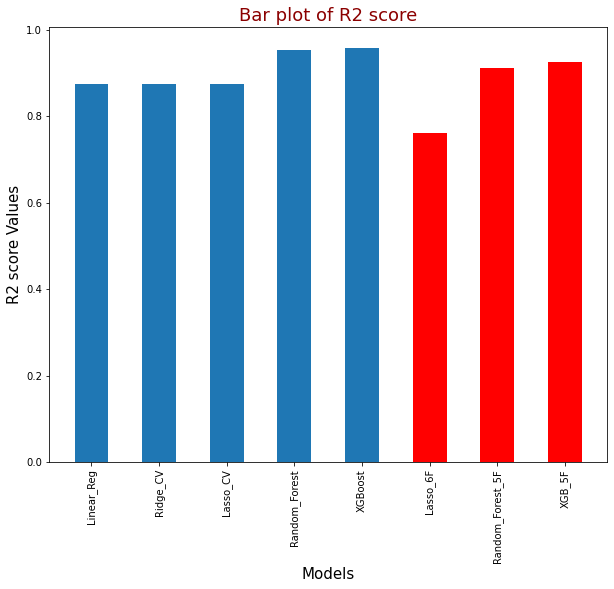

In [144]:
ploting('R2 score')

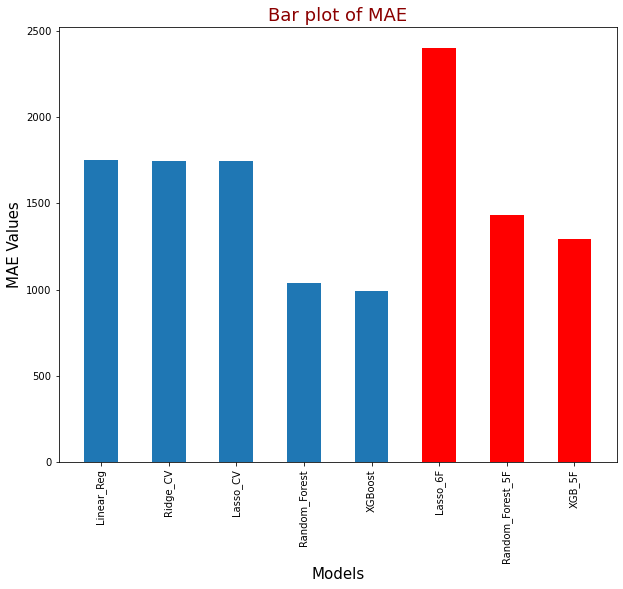

In [145]:
ploting('MAE')

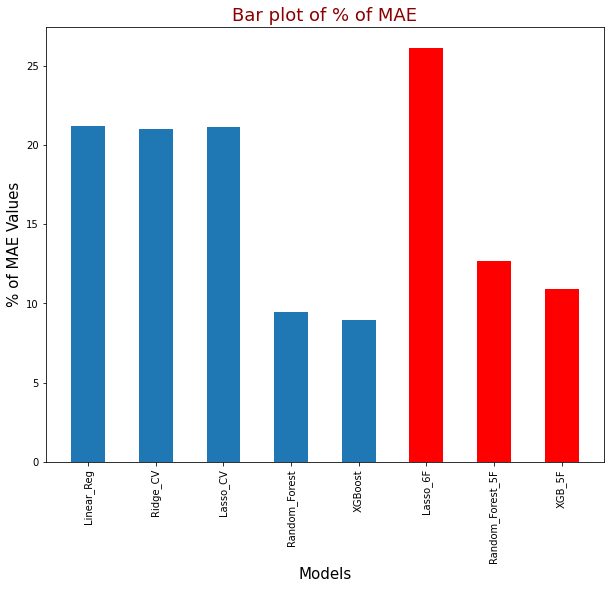

In [146]:
ploting('% of MAE')

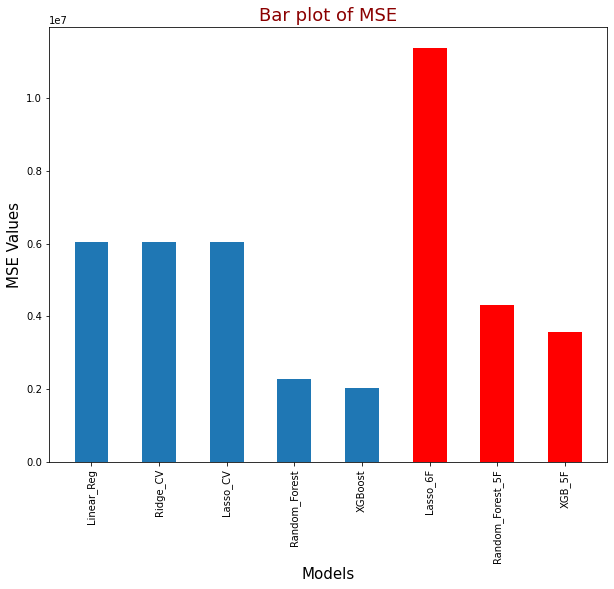

In [147]:
ploting('MSE')

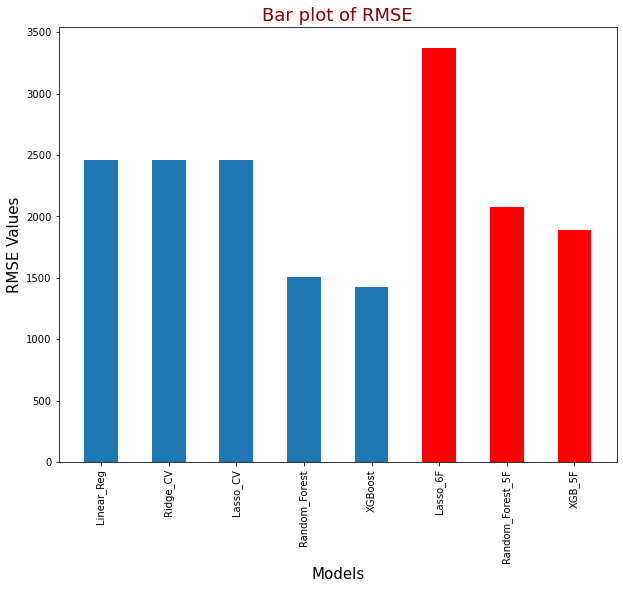

In [148]:
ploting('RMSE')

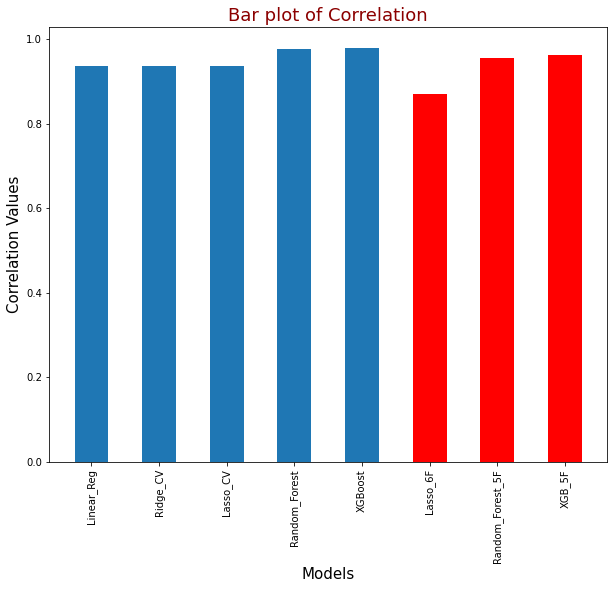

In [149]:
ploting('Correlation')

In [150]:
df_scores.to_excel('baseline_scores.xlsx')